In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory      
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fakenews-poland-clean-topics/embeddings_pl_herbert.csv
/kaggle/input/fakenews-poland-clean-topics/topics.csv
/kaggle/input/fakenews-poland-clean-topics/fake_news_features_combined.csv


In [3]:
!pip install sentence-transformers
!pip install transformers
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 298.1 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=e02acbbddc5abfa32e0f7795fed5cc2ccb2b8969373c28f5353a16884b5a65b9
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [4]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, HerbertTokenizer, BatchEncoding

import gc

In [5]:
torch.manual_seed(111)
np.random.seed(111)
random.seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()
    
device.type

'cuda'

## Get HerBERT

## Get data

In [6]:
df_topics = pd.read_csv('../input/fakenews-poland-clean-topics/topics.csv', index_col=0)

In [7]:
df = pd.read_csv('../input/fakenews-poland-clean-topics/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

df = df.copy()[['assestment', 'text_clean']][df.index.isin(df_topics.index)].reset_index(drop=True)

In [8]:
embeddings_table = pd.read_csv('../input/fakenews-poland-clean-topics/embeddings_pl_herbert.csv', sep=",", header=None).values

## Kfold

In [9]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv = df_topics.index[ ~np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, val_cv, test_cv])
    cv_fold_i.append( [train_cv_i, val_cv_i, test_cv_i])

In [10]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_index, val_index = train_test_split(train_index, test_size=1/9, shuffle=True)
    train_cv = df_topics.iloc[ train_index, : ].index.values
    val_cv = df_topics.iloc[ val_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    val_cv_i = df_topics.reset_index().iloc[ val_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, val_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, val_cv_i, test_cv_i])

## Train

## TripletLoss

In [11]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Net

In [12]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, emb_dim)
            
#             nn.Linear(1024, emb_dim),
#             nn.BatchNorm1d(emb_dim),
#             nn.ReLU(),
#             nn.Dropout(0.5),
        )
        
    def forward(self, x):
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

## Some testing one one kfold

In [13]:
train_index, val_index, test_index = cv_fold_i[0]

In [14]:
class FakeNews(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use, factor=5):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.repeat( [np.arange(index_to_use.shape[0])], factor, axis=0).reshape(-1)
        
        self.idx = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx): 
        item = self.index[idx]
        
        anchor_label = self.labels[item]

        positive_list = self.idx[self.idx!=item][self.labels[self.idx!=item]==anchor_label]

        positive_item = random.choice(positive_list)
        
        negative_list = self.idx[self.idx!=item][self.labels[self.idx!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        
        anchor_claim = self.emb[item].astype(np.float32)
        positive_claim = self.emb[positive_item].astype(np.float32)
        negative_claim = self.emb[negative_item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, positive_claim, negative_claim, anchor_label

class FakeNewsLabel(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.emb)
    
    def __getitem__(self, item):
        anchor_label = self.labels[item]
        
        anchor_claim = self.emb[item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, anchor_label

In [15]:
embedding_dims = 128
batch_size = 512
epochs = 200

In [16]:
train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index, 10)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

train_ds_label = FakeNewsLabel(embeddings_table, df['assestment'].values, train_index)
train_loader_label = DataLoader(train_ds_label, batch_size=batch_size, shuffle=True, num_workers=2)

val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = FakeNewsLabel(embeddings_table, df['assestment'].values, test_index)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [17]:
model = Network(embedding_dims)
# model = torch.nn.DataParallel(model)
# model = torch.jit.script(model).to(device)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.jit.script(TripletLoss())
criterion = TripletLoss()

In [18]:
# pp=0

# for p in model.parameters():
#     print(p.shape)
    
#     if(len(p.shape)>1):
#         pp += p.shape[0] * p.shape[1]
#     else:
#         pp += p.shape[0]

# pp

In [19]:
len(train_ds)

52700

## Training loop

In [ ]:
train_loss_out = []
val_loss_out = []

val_prev = np.inf

model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
        anchor_claim = anchor_claim.to(device) #(anchor_claim / torch.norm(anchor_claim) ).to(device)
        positive_claim = positive_claim.to(device) #(positive_claim / torch.norm(positive_claim) ).to(device)
        negative_claim = negative_claim.to(device) #(negative_claim / torch.norm(negative_claim) ).to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
        
    
    model.eval()
    
    val_loss = []
    for anchor_claim, positive_claim, negative_claim, _ in val_loader:
        anchor_claim = anchor_claim.to(device) #(anchor_claim / torch.norm(anchor_claim) ).to(device)
        positive_claim = positive_claim.to(device) #(positive_claim / torch.norm(positive_claim) ).to(device)
        negative_claim = negative_claim.to(device) #(negative_claim / torch.norm(negative_claim) ).to(device)

        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        val_loss.append(loss.cpu().detach().numpy())
    
    model.train()
    
    train_loss_out.append(np.mean(running_loss))
    val_loss_out.append(np.mean(val_loss))
    
    if np.mean(val_loss) < val_prev:
#         print(epoch, f'saved {np.mean(val_loss):.4f} < {val_prev:.4f}')
        val_prev = np.mean(val_loss)
        torch.save(model, 'model_0_001.pt')
        
    if epoch%10 == 0:
        print(f"Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
              f" Val Loss: {np.mean(val_loss):.4f} Best Val loss {val_prev:.4f}")
        
    if epoch%20 == 0 and epoch>1:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1/200 - Train Loss: 2.0030;  Val Loss: 0.9976 Best Val loss 0.9976
Epoch: 11/200 - Train Loss: 0.6086;  Val Loss: 0.4898 Best Val loss 0.4898
Epoch: 21/200 - Train Loss: 0.0907;  Val Loss: 0.2111 Best Val loss 0.1921
Epoch: 31/200 - Train Loss: 0.0299;  Val Loss: 0.2040 Best Val loss 0.1909
Epoch: 41/200 - Train Loss: 0.0197;  Val Loss: 0.2211 Best Val loss 0.1909
Epoch: 51/200 - Train Loss: 0.0153;  Val Loss: 0.2407 Best Val loss 0.1909
Epoch: 61/200 - Train Loss: 0.0134;  Val Loss: 0.2309 Best Val loss 0.1909
Epoch: 71/200 - Train Loss: 0.0127;  Val Loss: 0.2390 Best Val loss 0.1909
Epoch: 81/200 - Train Loss: 0.0137;  Val Loss: 0.2483 Best Val loss 0.1909
Epoch: 91/200 - Train Loss: 0.0135;  Val Loss: 0.2407 Best Val loss 0.1909
Epoch: 101/200 - Train Loss: 0.0131;  Val Loss: 0.2418 Best Val loss 0.1909
Epoch: 111/200 - Train Loss: 0.0135;  Val Loss: 0.2448 Best Val loss 0.1909


In [ ]:
model = torch.load('model_0_001.pt')

In [82]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for claim, label in tqdm(train_loader_label):
        anchor_claim = claim.to(device)
        
        train_results.append(model(anchor_claim).cpu().numpy())
        labels.append(label)
        
#         del anchor_claim 
#         gc.collect()
#         torch.cuda.empty_cache()

train_results = np.concatenate(train_results) 
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/42 [00:00<?, ?it/s]

(5270, 128)

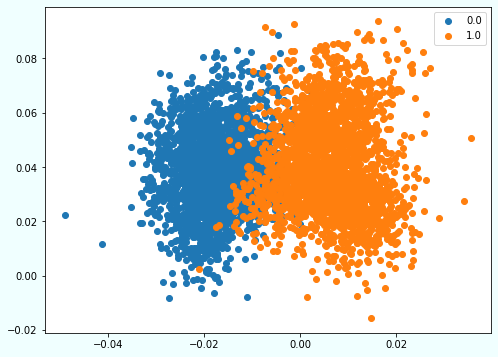

In [83]:
plt.figure(figsize=(8, 6), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [86]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for claim, label in tqdm(test_loader):
        anchor_claim = claim.to(device)
        
        test_results.append(model(anchor_claim).cpu().numpy())
        test_labels.append(label)
        
#         del anchor_claim 
#         gc.collect()
#         torch.cuda.empty_cache()

test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)
test_results.shape

  0%|          | 0/5 [00:00<?, ?it/s]

(595, 128)

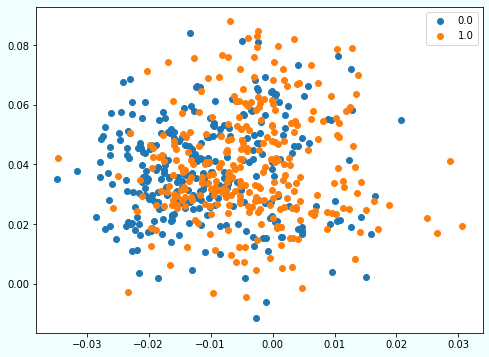

In [87]:
plt.figure(figsize=(8, 6), facecolor="azure")
for label in np.unique(test_labels):
    tmp = test_results[test_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [88]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [89]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


y_train_t = labels
X_train_t = train_results
y_test_t = test_labels
X_test_t = test_results

clf_lr_1.fit(X_train_t, y_train_t)

y_pred = clf_lr_1.predict(X_test_t)

results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

metrics = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

In [90]:
confusion_matrix(y_test_t, y_pred)

array([[211,  86],
       [110, 188]])

In [91]:
metrics

{'Accuracy': array([0.67058824]), 'F1 Score': array([0.65734266])}

# Test using CV

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 128
epochs = 1000
lr = 0.001

for j, (train_index, val_index, test_index) in enumerate(cv_fold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(embedding_dims)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = TripletLoss()

    val_prev = np.inf
    
    model.train()
    for epoch in tqdm(range(epochs), desc=f"Epochs {j}"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())

        model.eval()
    
        val_loss = []
        for anchor_claim, positive_claim, negative_claim, _ in val_loader:
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            val_loss.append(loss.cpu().detach().numpy())

        model.train()
        
        if np.mean(val_loss) < val_prev:
            val_prev = np.mean(val_loss)
            torch.save(model, f'model_cv{j}.pt')
        
        if epoch%100 == 0:
            print(f"{j} Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
                  f" Val Loss: {np.mean(val_loss):.4f} Val loss best {val_prev:.4f}"
             )
            
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in test_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

### Get use best models

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


for j, (train_index, val_index, test_index) in enumerate(cv_fold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(embedding_dims)
    model = torch.load(f'model_cv{j}.pt')
    model = model.to(device)

    model.eval()
   
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in test_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 128
epochs = 1000
lr = 0.001

for j, (train_index, val_index, test_index) in enumerate(cv_Kfold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(embedding_dims)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = TripletLoss()

    val_prev = np.inf
    
    model.train()
    for epoch in tqdm(range(epochs), desc=f"Epochs {j}"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())

        model.eval()
    
        val_loss = []
        for anchor_claim, positive_claim, negative_claim, _ in val_loader:
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            val_loss.append(loss.cpu().detach().numpy())

        model.train()
        
        if np.mean(val_loss) < val_prev:
            val_prev = np.mean(val_loss)
            torch.save(model, f'model_cv{j}.pt')
        
        if epoch%100 == 0:
            print(f"{j} Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
                  f" Val Loss: {np.mean(val_loss):.4f} Val loss best {val_prev:.4f}"
             )
            
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in test_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    